<a href="https://colab.research.google.com/github/noorceen/student-score-prediction/blob/main/student_score_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import files
import zipfile
import os

In [61]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive (1).zip


In [62]:
zip_file = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("dataset")

print("Fichiers extraits :", os.listdir("dataset"))

Fichiers extraits : ['StudentPerformanceFactors.csv']


In [63]:
csv_path = "dataset/" + os.listdir("dataset")[0]
df = pd.read_csv(csv_path)

df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [64]:
print("Dimensions du dataset :", df.shape)
df.info()

Dimensions du dataset : (6607, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influenc

In [65]:
# Séparated X et y
X = df.drop(columns=["Exam_Score"])
y = df["Exam_Score"]

In [66]:
# Replace missing values ​​with the most frequent value (mode)
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = X[col].fillna(X[col].mode()[0])

In [67]:
X = pd.get_dummies(X)

In [68]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [81]:
model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=2,
    subsample=0.7,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    validation_fraction=0.2,
    n_iter_no_change=10,
    tol=1e-4
)

model.fit(X_train, y_train)
print("Modèle entraîné avec Early Stopping et régularisation !")


Modèle entraîné avec Early Stopping et régularisation !


In [82]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE) :", mse)
print("R² Score :", r2)

Mean Squared Error (MSE) : 3.877969184566436
R² Score : 0.7256491473985289


In [83]:
feature_names = pd.get_dummies(df.drop(columns=["Exam_Score"])).columns
importances = model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("Top 10 des variables importantes :")
print(importance_df.head(10))

Top 10 des variables importantes :
                      Feature  Importance
1                  Attendance    0.467274
0               Hours_Studied    0.277724
3             Previous_Scores    0.052233
4           Tutoring_Sessions    0.038654
9    Access_to_Resources_High    0.024145
6   Parental_Involvement_High    0.023698
10    Access_to_Resources_Low    0.021008
7    Parental_Involvement_Low    0.016064
29    Peer_Influence_Positive    0.008975
20          Family_Income_Low    0.008050


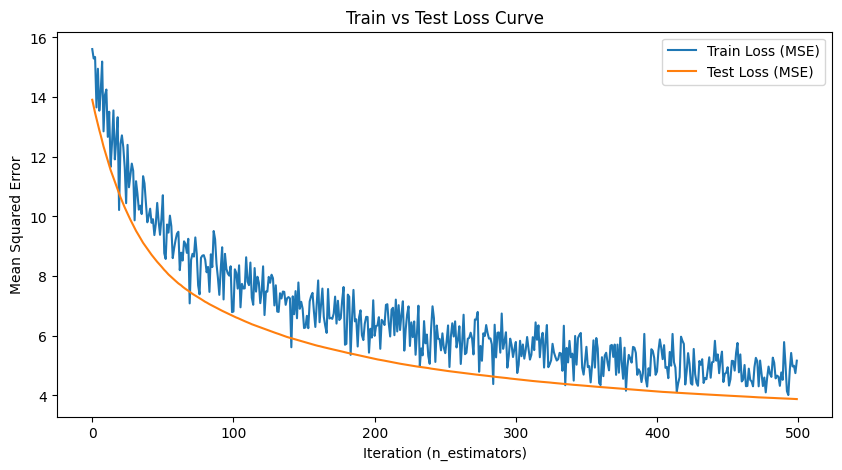

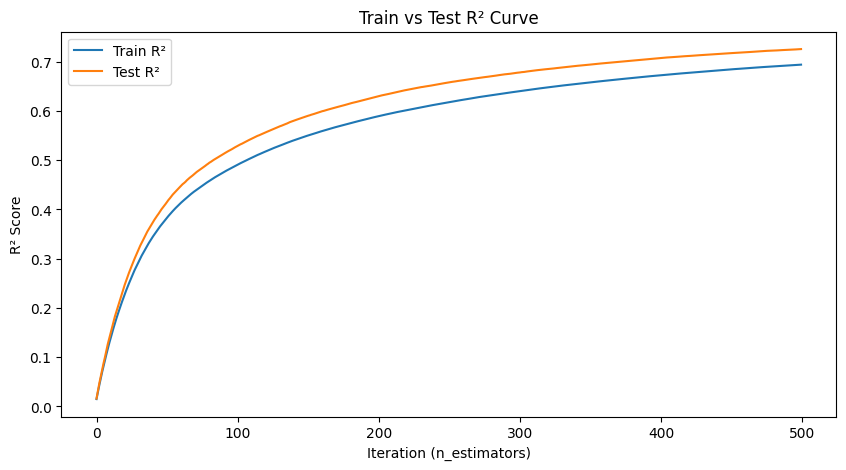

In [84]:
# Train/Test Loss
train_loss = model.train_score_
test_loss = [mean_squared_error(y_test, y_pred_iter) for y_pred_iter in model.staged_predict(X_test)]

plt.figure(figsize=(10,5))
plt.plot(train_loss, label="Train Loss (MSE)")
plt.plot(test_loss, label="Test Loss (MSE)")
plt.xlabel("Iteration (n_estimators)")
plt.ylabel("Mean Squared Error")
plt.title("Train vs Test Loss Curve")
plt.legend()
plt.show()

# Train/Test R²
train_r2 = [r2_score(y_train, y_pred_iter) for y_pred_iter in model.staged_predict(X_train)]
test_r2 = [r2_score(y_test, y_pred_iter) for y_pred_iter in model.staged_predict(X_test)]

plt.figure(figsize=(10,5))
plt.plot(train_r2, label="Train R²")
plt.plot(test_r2, label="Test R²")
plt.xlabel("Iteration (n_estimators)")
plt.ylabel("R² Score")
plt.title("Train vs Test R² Curve")
plt.legend()
plt.show()